# Unsupervised Clustering

In [2]:
import matplotlib.pyplot as plt
import numpy as np

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


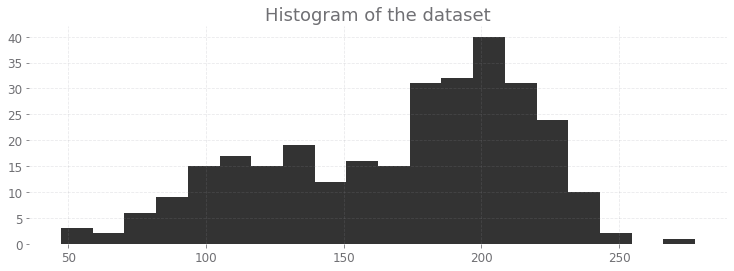

In [4]:
plt.figure(figsize=(12.5, 4))
data = np.loadtxt("../data/mixture_data.csv", delimiter=",")
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

## Mixture Model

In [5]:
import pymc3 as pm
import theano.tensor as T

### Cluster Assignment

In [10]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0., 1.)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical('assignment', p, shape=data.shape[0])

### Cluster Characteristics

In [11]:
with model:
    sds = pm.Uniform("sds", 0., 100., shape=2)  # we assume 2 clusters
    centers = pm.Normal("centers",
                       mu=np.array([120, 190]),
                       sd=np.array([10, 10]),
                       shape=2)
    center_i = pm.Deterministic("center_i", centers[assignment])
    sd_i = pm.Deterministic("sd_i", sds[assignment])
    
    # sample from selected cluster
    obs = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)

## Inference

In [12]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 148 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Trace Plot

In [18]:
from colors import colors

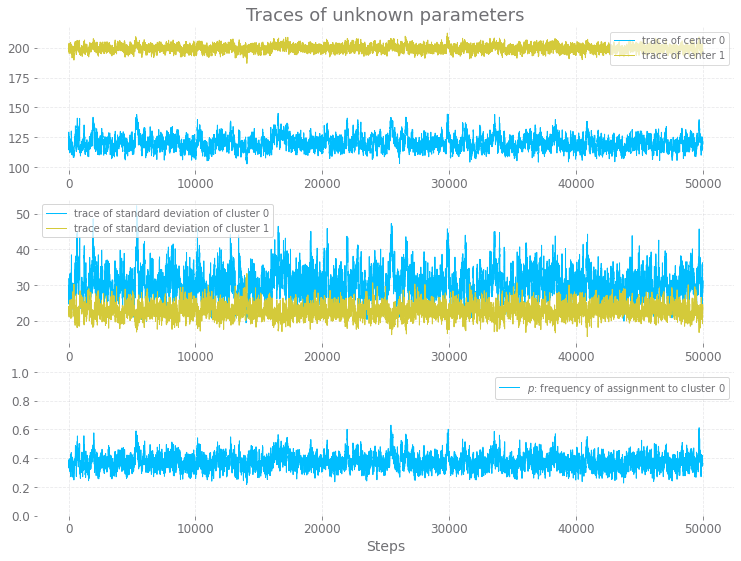

In [19]:
plt.figure(figsize=(12.5, 9))
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
#colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
#    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

## Posterior Distribution of Unknowns

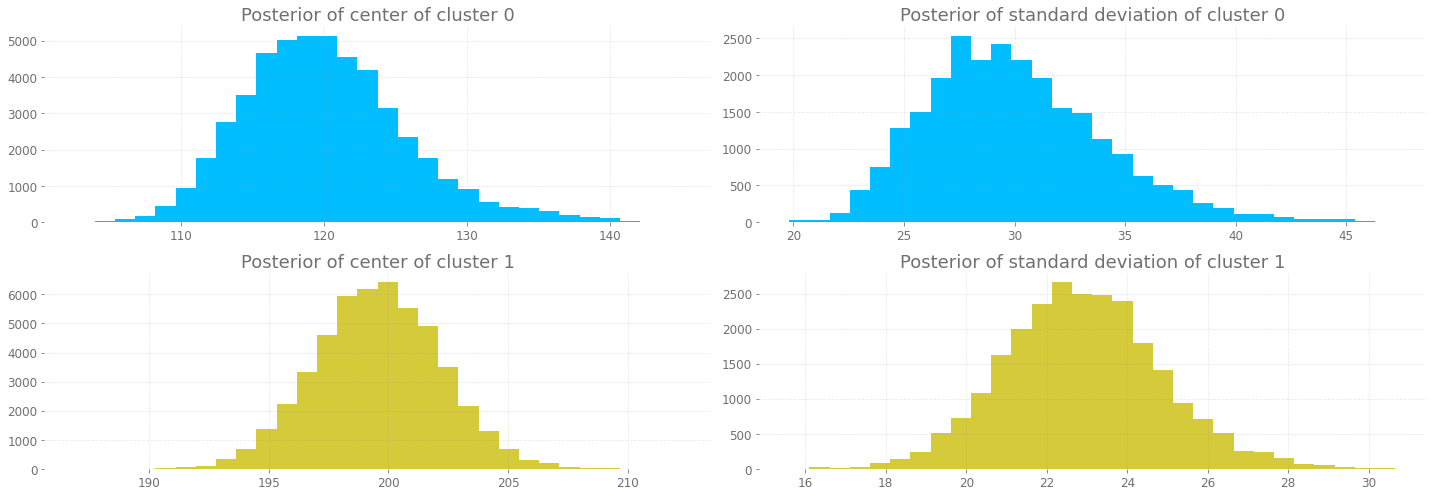

In [30]:
plt.figure(figsize=(20.0, 7))
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

## Posterior Labels

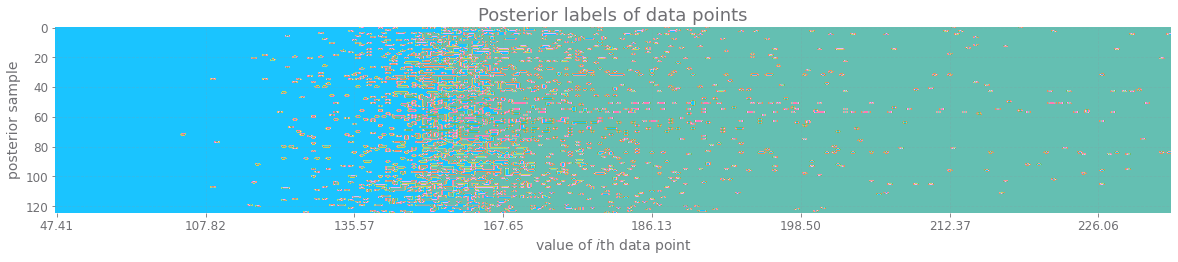

In [27]:
import matplotlib as mpl
plt.figure(figsize=(20., 6.))
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

## Probability of belonging to Cluster $0$

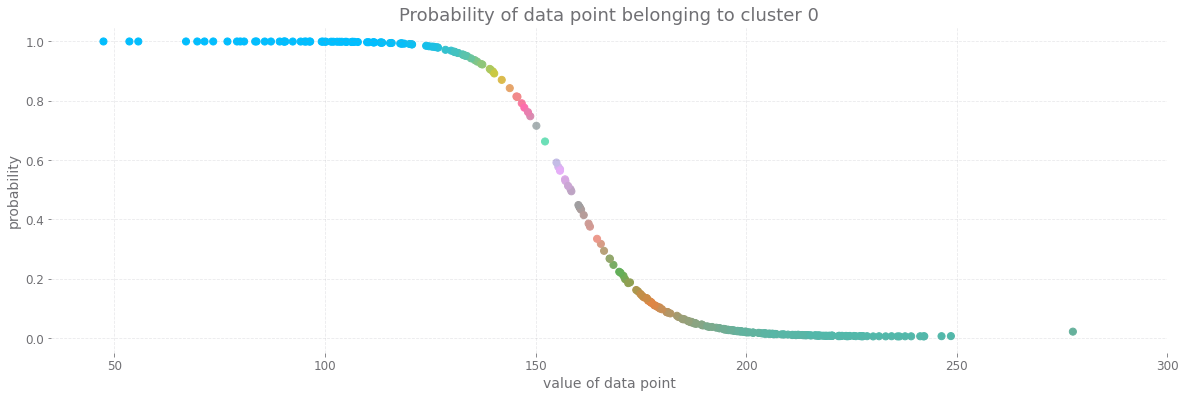

In [26]:
plt.figure(figsize=(20., 6.))
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");